In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import statsmodels.api as sm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble

# Model 1

In [3]:
#load data into test and train sets
df1=pd.read_csv("C:/Users/Public/Output/adult_icu/adult_icu.csv")


binary_cols = ['first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other', 'eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT']
non_binary_cols = [item for item in df1.columns if item not in binary_cols]

#Scaling the data
# MimMaxScaler is used because StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_nb_scaled = scaler.fit_transform(df1[non_binary_cols])
df_nb_scaled = pd.DataFrame(df_nb_scaled, columns=non_binary_cols)
df_scaled = df_nb_scaled.join(df1[binary_cols])
df1 = df_scaled
#Seperating test and train sets
df1_test = df1.loc[df1['train'] == 0]
df1_train = df1.loc[df1['train'] == 1]


#specify the feature columns and output variable
feature_cols=['age','first_hosp_stay','first_icu_stay','adult_icu','eth_asian','eth_black',
'eth_hispanic','eth_other','eth_white','admType_ELECTIVE','admType_EMERGENCY','admType_NEWBORN','admType_URGENT',
'heartrate_min','heartrate_max','heartrate_mean','sysbp_min','sysbp_max','sysbp_mean','diasbp_min','diasbp_max',
'diasbp_mean','meanbp_min','meanbp_max','meanbp_mean','resprate_min','resprate_max','resprate_mean','tempc_min',
'tempc_max','tempc_mean','spo2_min','spo2_max','spo2_mean','glucose_min','glucose_max','glucose_mean','aniongap',
'albumin','bicarbonate','bilirubin','creatinine','chloride','glucose','hematocrit','hemoglobin','lactate','magnesium',
'phosphate','platelet','potassium','ptt','inr','pt','sodium','bun','wbc']

X1_train = df1_train[feature_cols]
y1_train = df1_train.mort_icu
X1_test = df1_test[feature_cols]
y1_test = df1_test.mort_icu

#Training logistic regression model
logreg1 = LogisticRegression(solver='lbfgs',penalty='l2',max_iter=5000)
logreg1.fit(X1_train,y1_train)

#Predicting using the trained model
y1_pred=logreg1.predict(X1_test)



In [49]:
y1_pred_proba = logreg1.predict_proba(X1_test)

# Model 2

In [5]:
#Reading data to a pandas dataframe
df=pd.read_csv("C:/Users/Public/Output/adult_notes/adult_notes.csv")
#converting from object to string
df['chartext'] = df['chartext'].astype(str)

In [6]:

#Tokenize and remove punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['chartext'] = df.apply(lambda row: tokenizer.tokenize(str(row['chartext'])), axis=1)
df['chartext'] = df['chartext'].astype(str)


In [7]:
#split into test and train data
df_test = df.loc[df['train'] == 0]
df_train = df.loc[df['train'] == 1]
x_train=df_train['chartext']
y_train=df_train['mort_icu'] 
x_test=df_test['chartext']
y_test=df_test['mort_icu']

In [8]:
#TDIDF on train data and removing stopwords
vectorizer = TfidfVectorizer(lowercase=True,analyzer='word',token_pattern='[A-Za-z]+',stop_words= 'english',ngram_range=(1,1))
train_vect = vectorizer.fit_transform(df_train['chartext'])
train_vect

<19166x105220 sparse matrix of type '<class 'numpy.float64'>'
	with 9647858 stored elements in Compressed Sparse Row format>

In [9]:
#TDIDF on test data x_test.apply(lambda x: np.str_(x))
test_vect = vectorizer.transform(x_test)

In [10]:
#Regression model
logreg = LogisticRegression(penalty='l1',max_iter=5000)
logreg.fit(train_vect,y_train)

C:\Users\manis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred=logreg.predict(test_vect)
y_pred_proba = logreg.predict_proba(test_vect)

# Combining model

In [60]:
#Using bagging and avergaing the predictions of both the classifiers
Y_merged_prob = (y_pred_proba+y1_pred_proba)/2

AUC SCORE IS:0.8612316113661884


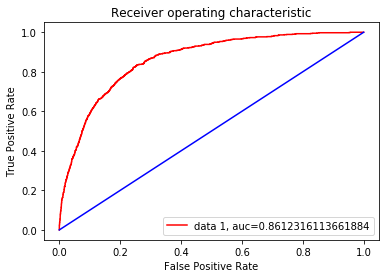

In [63]:
#ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, Y_merged_prob[:,1])
auc = metrics.roc_auc_score(y_test, Y_merged_prob[:,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
print("AUC SCORE IS:"+str(auc) )
plt.plot([0, 1], [0, 1], color='blue')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()